## Imports

In [18]:
import tensorflow as tf

import os
import datetime
import time

import pyvista as pv
from matplotlib import pyplot as plt
from IPython import display

### Reading `.vti` with PyVista

/home/antonio/facul/TCC/acwv-postprocessing/.venv/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


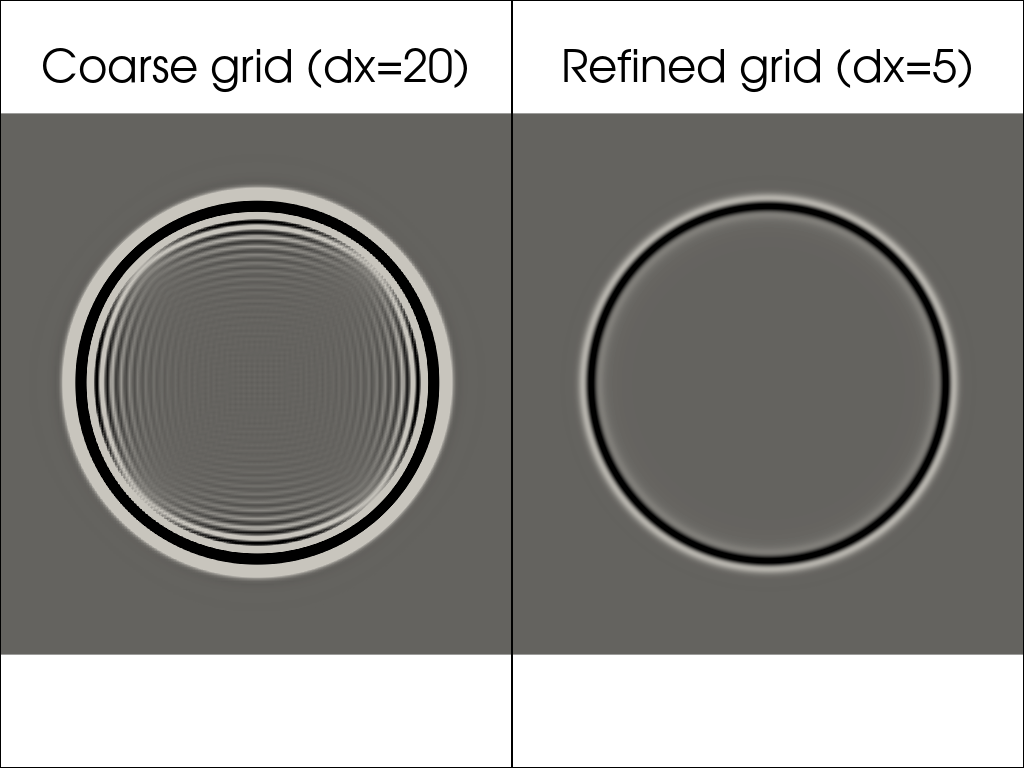

In [19]:
coarse_grid = pv.read("./sample/coarse_grid/output_data_0_15.vti")
refined_grid = pv.read("./sample/refined_grid/output_data_0_15.vti")

plotter = pv.Plotter(shape=(1, 2), border=True)

plotter.subplot(0, 0)
plotter.add_mesh(coarse_grid, cmap="grey", clim=(-0.5, 0.5), show_scalar_bar=False)
plotter.add_title("Coarse grid (dx=20)")
plotter.view_xy()
plotter.camera.zoom(1.5)

plotter.subplot(0, 1)
plotter.add_mesh(refined_grid, cmap="grey", clim=(-0.5, 0.5), show_scalar_bar=False)
plotter.add_title("Refined grid (dx=5)")
plotter.view_xy()
plotter.camera.zoom(1.5)

plotter.show()

# `pix2pix` implementation

### Load .vti files and convert to tensor

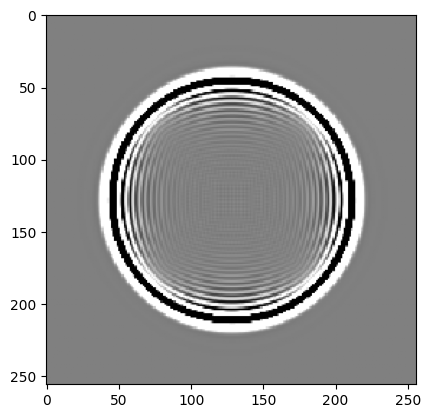

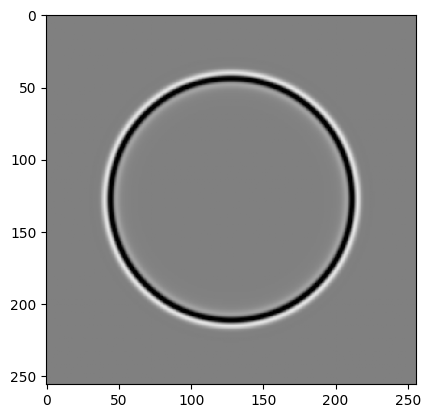

In [20]:
def resize(input_image, real_image, height, width):
  input_image = tf.expand_dims(input_image, axis=-1)
  real_image = tf.expand_dims(real_image, axis=-1)

  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def load(input_file_path, real_file_path):
    input_grid = pv.read(input_file_path)
    input_data = input_grid.active_scalars
    input_dims = input_grid.dimensions
    input_nx, input_ny = input_dims[0], input_dims[1]

    input_image = input_data.reshape((input_ny, input_nx))
    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)

    real_grid = pv.read(real_file_path)
    real_data = real_grid.active_scalars
    real_dims = real_grid.dimensions
    real_nx, real_ny = real_dims[0], real_dims[1]

    real_image = real_data.reshape((real_ny, real_nx))
    real_tensor = tf.convert_to_tensor(real_image, dtype=tf.float32)

    return resize(input_tensor, real_tensor, 256, 256)

inp, re = load('./sample/coarse_grid/output_data_0_15.vti', './sample/refined_grid/output_data_0_15.vti')

plt.figure()
plt.imshow(inp, cmap='grey', vmin=-.5, vmax=.5)
plt.figure()
plt.imshow(re, cmap='grey', vmin=-.5, vmax=.5)

### Split data into training/testing

In [21]:
! bash ./split_data.sh ./sample/coarse_grid "output_data_0" "input"
! bash ./split_data.sh ./sample/refined_grid "output_data_0" "real"

Copied 33 files to 'train' and 8 to 'test'.
Copied 33 files to 'train' and 8 to 'test'.


### Building input Pipeline

In [22]:
def load_from_tensor(input_path_tensor, real_path_tensor):
    return load(input_path_tensor.numpy().decode('utf-8'), real_path_tensor.numpy().decode('utf-8'))

def load_wrapper(input_path, real_path):
    input_tensor, real_tensor = tf.py_function(
        func=load_from_tensor,
        inp=[input_path, real_path],
        Tout=[tf.float32, tf.float32]
    )
    # input_tensor.set_shape([256, 256])  # adjust based on actual shape
    # real_tensor.set_shape([256, 256])
    return input_tensor, real_tensor

def make_dataset(dir_path, batch_size=16, shuffle=True, repeat=False):
    # Get all input and real files sorted to match
    input_files = sorted(tf.io.gfile.glob(os.path.join(dir_path, "input_*.vti")))
    real_files = sorted(tf.io.gfile.glob(os.path.join(dir_path, "real_*.vti")))
    # input_files = sorted([os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.startswith('input_')])
    # real_files = sorted([os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.startswith('real_')])

    dataset = tf.data.Dataset.from_tensor_slices((input_files, real_files))

    dataset = dataset.map(load_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=32)

    if repeat:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


In [23]:
train_dataset = make_dataset("train", batch_size=1)
test_dataset = make_dataset("test", batch_size=1, shuffle=False)

### Build the generator

In [24]:
OUTPUT_CHANNELS = 1

In [25]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [26]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 128, 128, 3)


In [27]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [28]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
    downsample(64, 2, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 2),  # (batch_size, 64, 64, 128)
    downsample(256, 2),  # (batch_size, 32, 32, 256)
    downsample(512, 2),  # (batch_size, 16, 16, 512)
    downsample(512, 2),  # (batch_size, 8, 8, 512)
    downsample(512, 2),  # (batch_size, 4, 4, 512)
    downsample(512, 2),  # (batch_size, 2, 2, 512)
    downsample(512, 2),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 2, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 2, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 2, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 2),  # (batch_size, 16, 16, 1024)
    upsample(256, 2),  # (batch_size, 32, 32, 512)
    upsample(128, 2),  # (batch_size, 64, 64, 256)
    upsample(64, 2),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

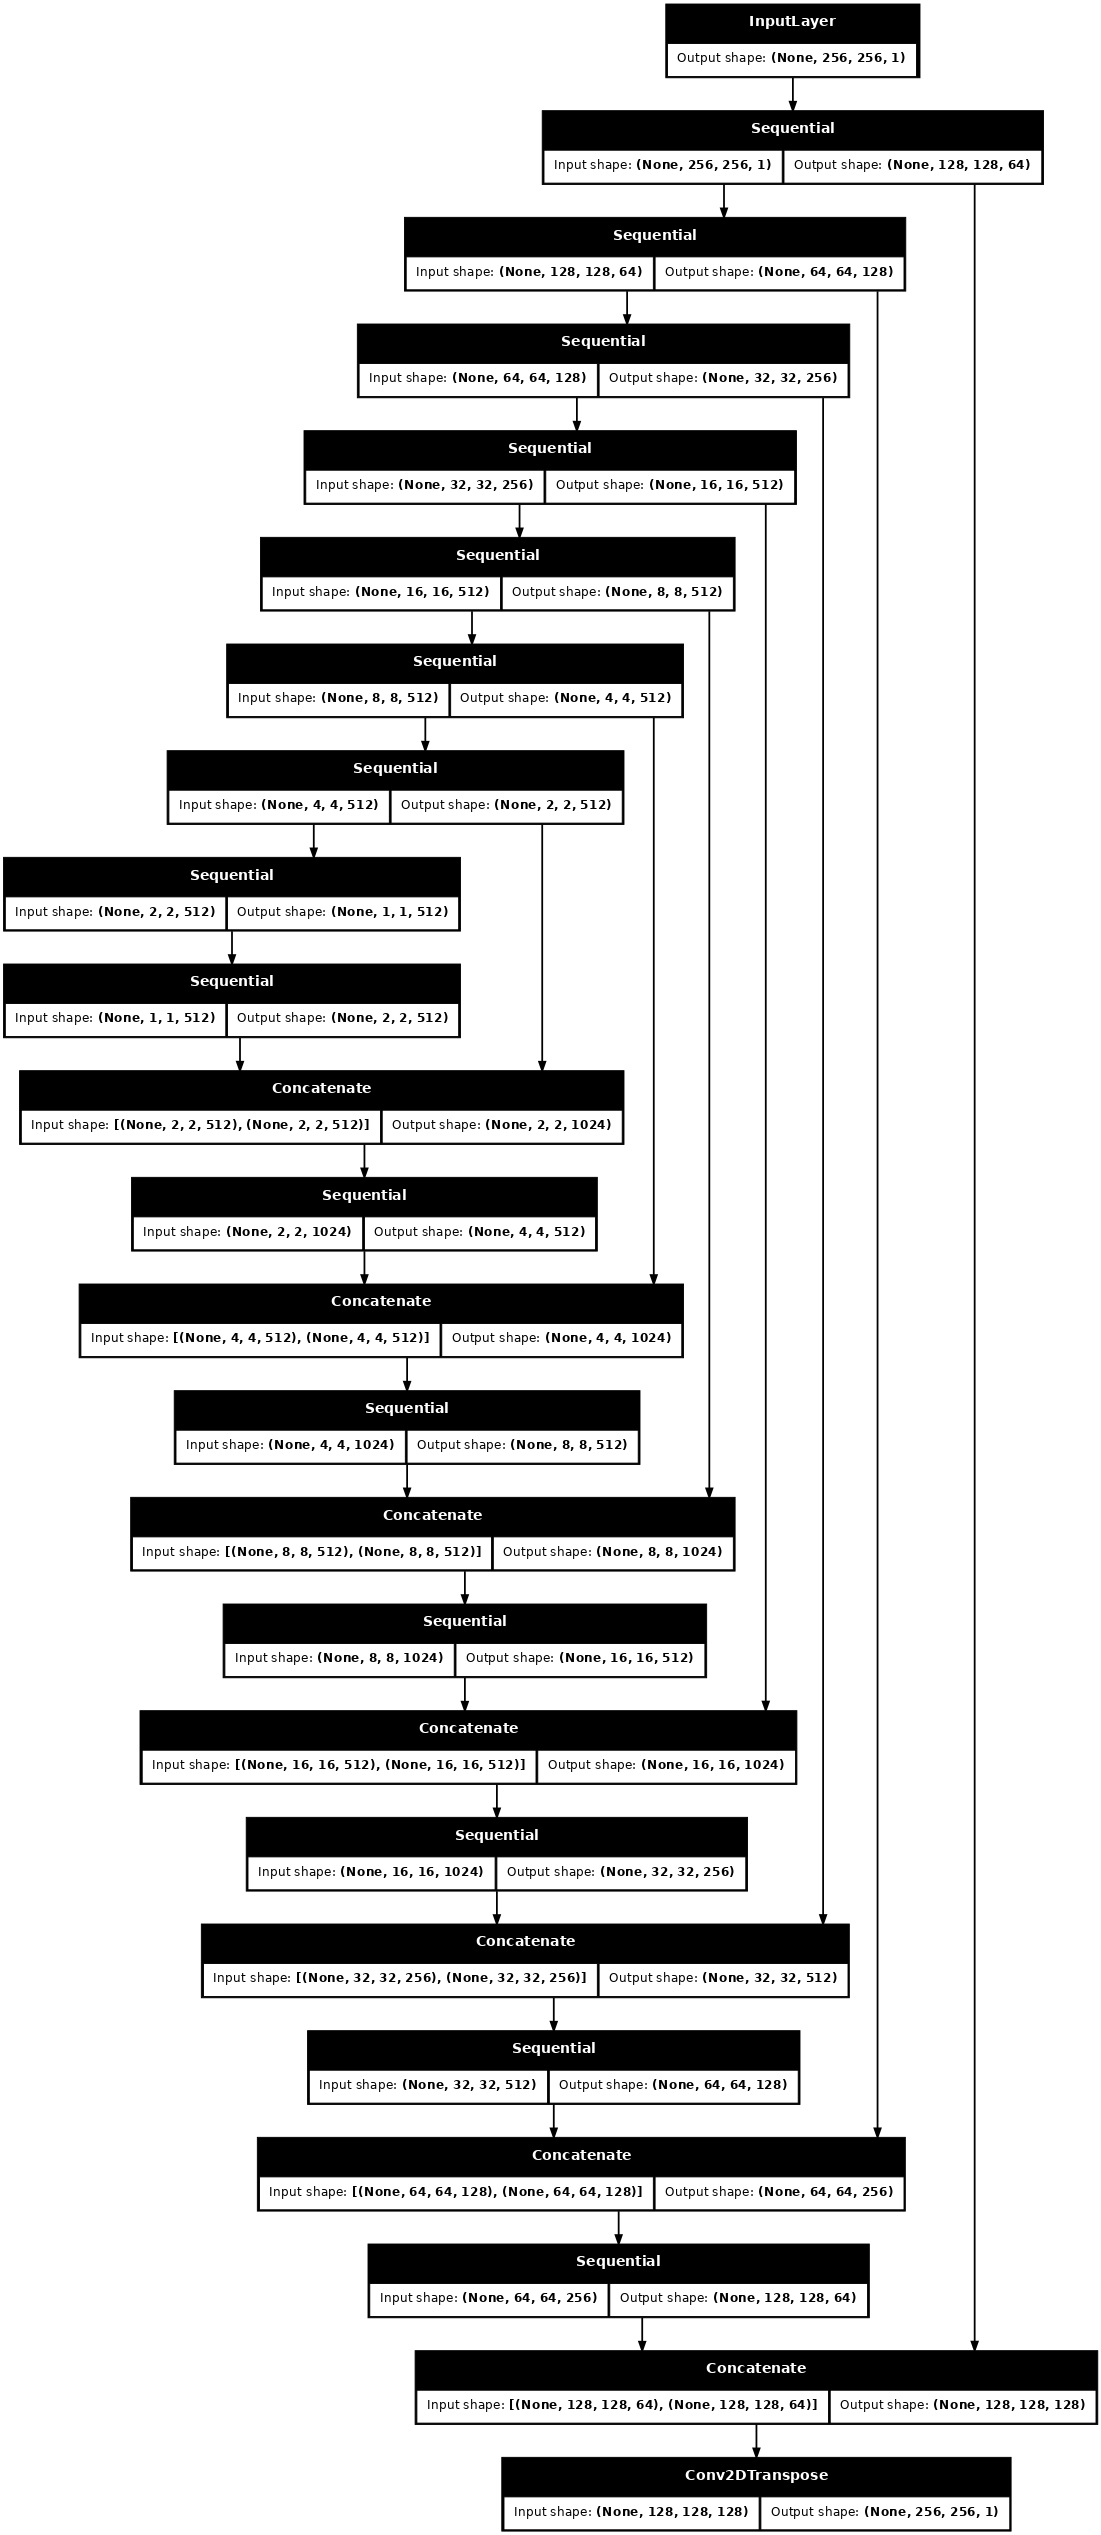

In [29]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

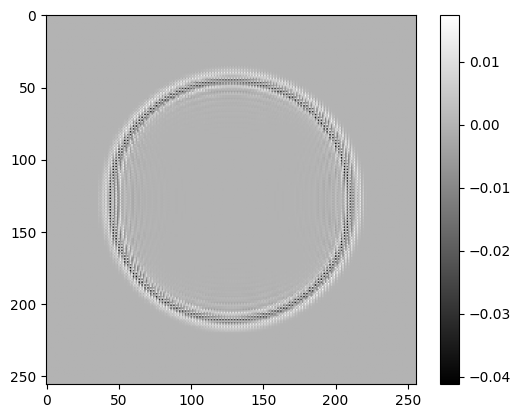

In [30]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...], cmap='grey')
plt.colorbar()

In [31]:
LAMBDA = 100

In [32]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [34]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 2, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

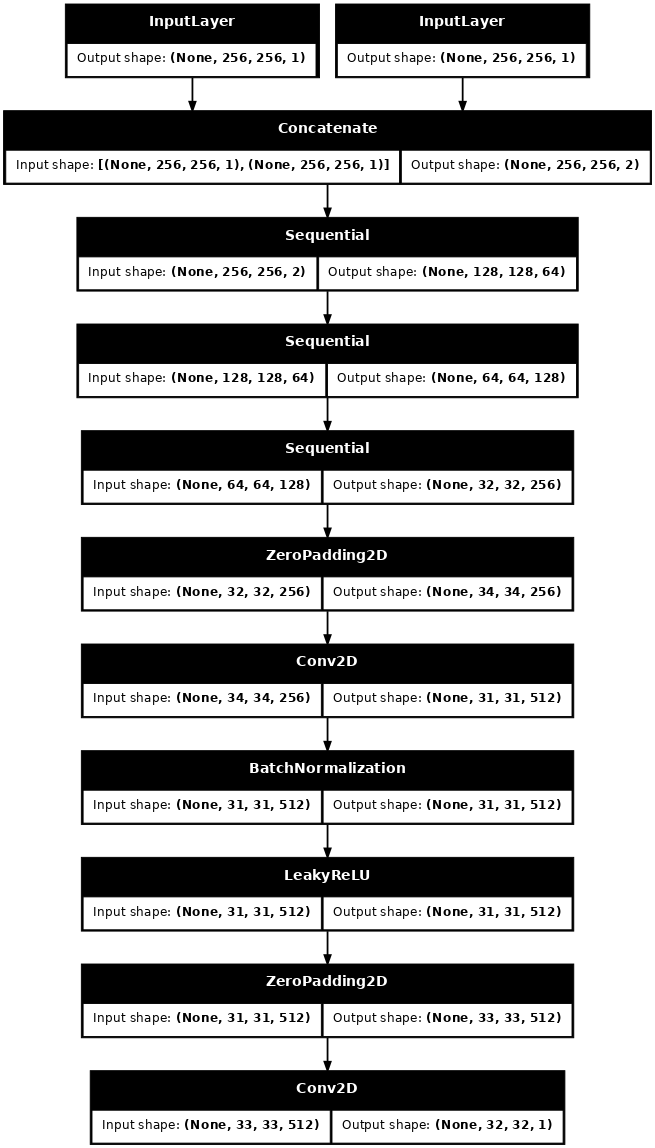

In [35]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

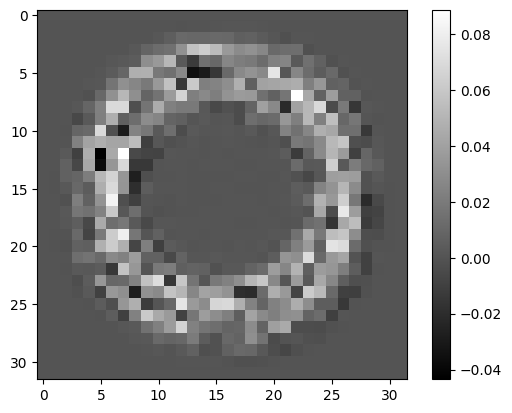

In [36]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], cmap='grey')
plt.colorbar()

In [37]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [59]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i], vmin=-.5, vmax=.5, cmap='grey')
    plt.axis('off')
  plt.show()

## Training

In [41]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [42]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [43]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [44]:
example_input, example_target = next(iter(test_dataset.take(1)))

Time taken for 1000 steps: 241.07 sec



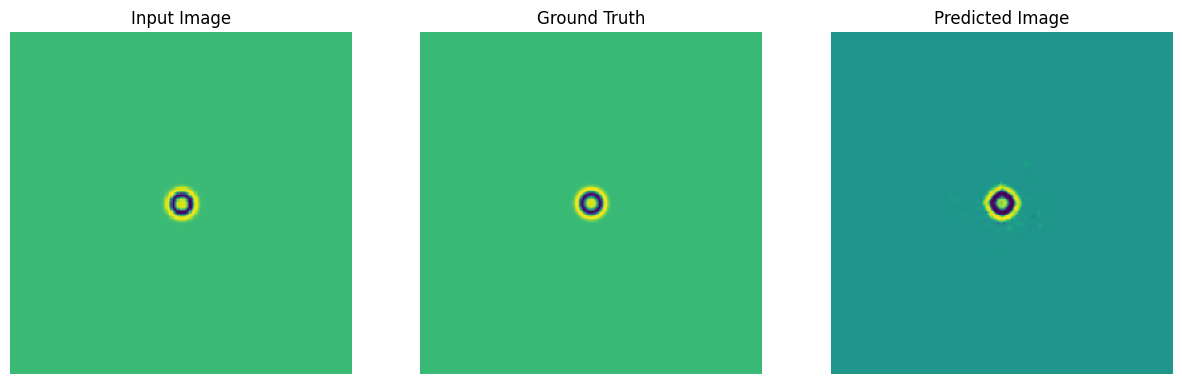

Step: 39k
....................................................................................................

2025-07-04 13:15:43.187245: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
fit(train_dataset, test_dataset, steps=40000)

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

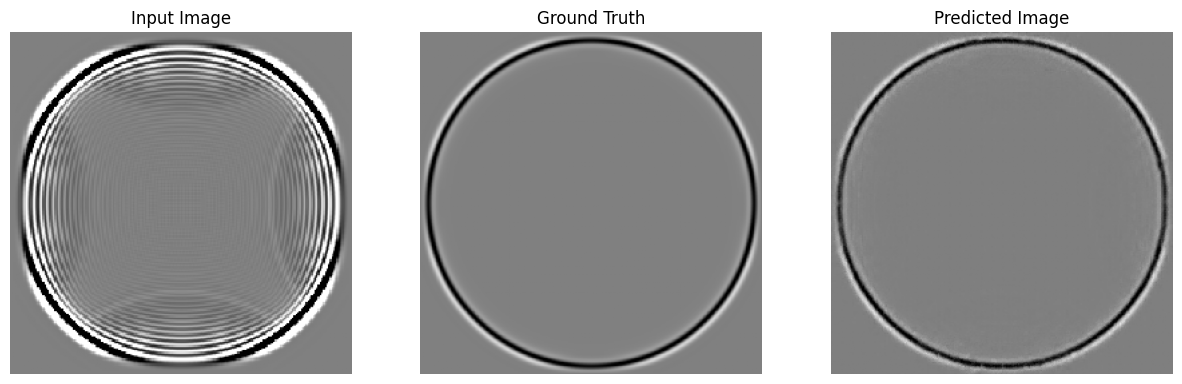

In [64]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

inp, re = load('./sample/coarse_grid/output_data_0_21.vti', './sample/refined_grid/output_data_0_21.vti')

generate_images(generator, inp[tf.newaxis, ...], re[tf.newaxis, ...])